In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-ncsu", group="lehigh-universit", project="qc-error-model") # ibm-q-ncsu/lehigh-universit/qc-error-model
name = "ibmq_jakarta"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
data_folder = "Noisy_Id_Data/"

n_qubits = 4
reps = 8
max_num_itrs = 10

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.963, 0.03700000000000003], [0.038, 0.962]],
 'gate_qubits': [(6,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-06-15 06:30:33-04:00


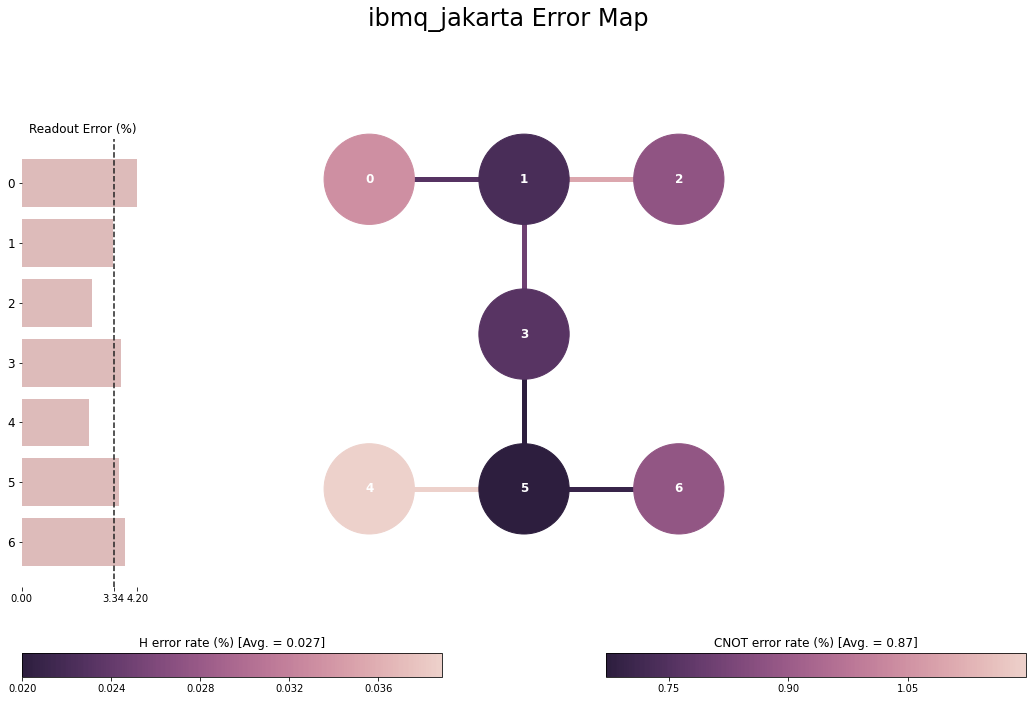

In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.cx(1,3)
    iterate.barrier()
    iterate.cx(1,3)
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

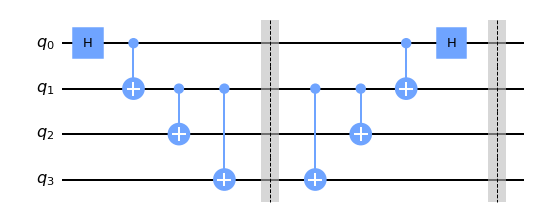

In [8]:
single_iter(n_qubits).draw("mpl")

In [9]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 121
T1: 0.00012638690371831915 sec
T2: 4.420988607509688e-05 sec
Circuit Operation Time: 2.4124444444444445e-05 sec


## Collect Measurement Data from Real Machine

In [10]:
job_list = []
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=backend).copy(name=str(i))
    job_list.append(trans_circ)
iter_job = execute(job_list,shots=8192,backend=backend)
job_monitor(iter_job)

Job Status: job has successfully run


In [11]:
print(iter_job.job_id())  # 62a9be8c34dced2a5b906295

62a9be8c34dced2a5b906295


In [12]:
real_probs = [] # measurement result
for i in range(1, max_num_itrs+1):
    iter_res = iter_job.result()
    iter_vec = KSEM.dictToVec(iter_res.get_counts(str(i)))
    real_probs.append(iter_vec)
    
# Save to numpy
np.save(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec_4qubit.npy',np.array(real_probs))

In [13]:
# Load
real_probs = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec_4qubit.npy')

## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [14]:
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 0
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

In [15]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)
# Obtain Measurement Error Matrix
qr = QuantumRegister(n_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for i in range(len(meas_calibs)):
    meas_calibs[i] = transpile(meas_calibs[i],den_simu)

job_meas = den_simu.run(meas_calibs,shots=reps*8192,optimization_level=0)
cal_results = job_meas.result()
meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter
cal_mat= meas_filter.cal_matrix
np.save(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat_4qubit.npy', cal_mat)

C:\Users\a1996\AppData\Local\Temp/ipykernel_26412/3271758006.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)


In [16]:
cal_mat = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat_4qubit.npy')
cal_mat

array([[9.21844482e-01, 4.55780029e-02, 4.33654785e-02, 2.24304199e-03,
        4.03137207e-02, 1.98364258e-03, 1.83105469e-03, 7.62939453e-05,
        5.89904785e-02, 2.94494629e-03, 2.41088867e-03, 1.83105469e-04,
        2.42614746e-03, 1.22070312e-04, 1.06811523e-04, 1.52587891e-05],
       [3.70178223e-02, 9.13238525e-01, 1.80053711e-03, 4.27093506e-02,
        1.93786621e-03, 3.96881104e-02, 7.62939453e-05, 1.67846680e-03,
        2.48718262e-03, 5.80291748e-02, 7.62939453e-05, 2.41088867e-03,
        1.06811523e-04, 2.39562988e-03, 1.52587891e-05, 1.22070312e-04],
       [1.99127197e-02, 1.06811523e-03, 8.99368286e-01, 4.41894531e-02,
        7.32421875e-04, 4.57763672e-05, 3.88946533e-02, 1.73950195e-03,
        1.02233887e-03, 3.05175781e-05, 5.66711426e-02, 2.89916992e-03,
        4.57763672e-05, 0.00000000e+00, 2.38037109e-03, 1.22070312e-04],
       [7.78198242e-04, 1.95007324e-02, 3.48358154e-02, 8.90838623e-01,
        1.52587891e-05, 1.06811523e-03, 1.54113770e-03, 3.784

In [17]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [18]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'1000': 776,
 '0000': 51992,
 '0011': 618,
 '1111': 82,
 '0110': 234,
 '0001': 8637,
 '0111': 250,
 '0010': 1595,
 '0100': 630,
 '1001': 291,
 '1011': 26,
 '1010': 33,
 '0101': 244,
 '1110': 94,
 '1100': 22,
 '1101': 12}

In [19]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.8982281877592624
0.8131901126982997
0.7419411079303929
0.6820636812759984
0.6315726702137615
0.5888374866111186
0.5525183703447677
0.521514126433207
0.49491927564467614
0.47198892177768603

Prob Vec
[8.75488281e-01 7.17010498e-02 2.23846436e-02 3.69262695e-03
 8.78906250e-03 1.44958496e-03 1.40380859e-03 1.34277344e-03
 1.04522705e-02 1.84631348e-03 2.59399414e-04 6.10351562e-05
 1.98364258e-04 6.10351562e-05 3.66210938e-04 5.03540039e-04]
[8.35479736e-01 1.03347778e-01 2.10876465e-02 6.63757324e-03
 8.88061523e-03 2.50244141e-03 2.10571289e-03 2.36511230e-03
 1.17340088e-02 3.20434570e-03 3.50952148e-04 1.37329102e-04
 2.28881836e-04 1.67846680e-04 8.69750977e-04 9.00268555e-04]
[7.93640137e-01 1.33270264e-01 2.32086182e-02 8.95690918e-03
 1.01165771e-02 3.96728516e-03 3.58581543e-03 3.75366211e-03
 1.20086670e-02 4.19616699e-03 4.88281250e-04 2.13623047e-04
 1.83105469e-04 1.98364258e-04 1.05285645e-03 1.15966797e-03]
[7.53768921e-01 1.61193848e-01 2.59094238e-02 1.21307373e

## Kalman Smoother

In [20]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [21]:
real_probs

array([[7.51953125e-01, 1.17187500e-01, 4.23583984e-02, 3.63769531e-02,
        1.59912109e-02, 6.46972656e-03, 5.12695312e-03, 4.15039062e-03,
        7.44628906e-03, 4.63867188e-03, 4.88281250e-04, 4.88281250e-04,
        2.44140625e-04, 2.44140625e-04, 1.46484375e-03, 5.37109375e-03],
       [5.68725586e-01, 2.73193359e-01, 4.40673828e-02, 2.85644531e-02,
        2.12402344e-02, 1.62353516e-02, 1.08642578e-02, 7.56835938e-03,
        1.14746094e-02, 8.91113281e-03, 1.09863281e-03, 9.76562500e-04,
        9.76562500e-04, 6.10351562e-04, 2.44140625e-03, 3.05175781e-03],
       [3.60961914e-01, 3.87084961e-01, 5.85937500e-02, 5.70068359e-02,
        2.33154297e-02, 2.61230469e-02, 1.98974609e-02, 2.13623047e-02,
        1.15966797e-02, 1.63574219e-02, 2.68554688e-03, 2.19726562e-03,
        1.34277344e-03, 1.09863281e-03, 3.54003906e-03, 6.83593750e-03],
       [2.22534180e-01, 4.68261719e-01, 5.82275391e-02, 6.71386719e-02,
        2.83203125e-02, 3.52783203e-02, 2.85644531e-02, 3.784

In [22]:
initial_state = np.array([0]*(real_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [23]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = real_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1+1j)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [24]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(256, 256, 16, 65536)

### EM and Smoother - Total

Use longest iterations

In [25]:
total_smoother_dens = []
total_smoother_purs = []

observs = real_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 

x_est_norms = []
for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape(num_dim_obs, num_dim_obs)
#     x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll 3511.83, Last ll 3501.83
Iteration     1, New log-likelihood 3.53496e+03, Last log-likelihood 3.51183e+03, Change 2.31240e+01
Iteration     2, New log-likelihood 1.22181e+08, Last log-likelihood 3.53496e+03, Change 1.22178e+08
Iteration     3, New log-likelihood 3.28260e+09, Last log-likelihood 1.22181e+08, Change 3.16042e+09


Only use the estimation in the final iteration as the valid output

In [26]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     observs = real_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape(num_dim_obs, num_dim_obs)
#     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [27]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [28]:
with np.printoptions(precision=3, suppress=True):
#     for den in total_smoother_dens:
#         print(den)
    print(total_smoother_dens[8])
    print(total_simu_dens[8].data)

[[ 0.224-0.j -0.   -0.j -0.   -0.j -0.   -0.j -0.   -0.j -0.   -0.j
  -0.   -0.j -0.   -0.j -0.   -0.j -0.   -0.j -0.   -0.j -0.   -0.j
  -0.   -0.j -0.   -0.j -0.   -0.j -0.   -0.j]
 [-0.   +0.j  0.201-0.j -0.   -0.j -0.   -0.j -0.   -0.j -0.   +0.j
  -0.   +0.j -0.   +0.j -0.   -0.j -0.   -0.j -0.   +0.j -0.   +0.j
  -0.   -0.j -0.   -0.j -0.   -0.j -0.   -0.j]
 [-0.   +0.j -0.   +0.j  0.07 -0.j  0.   +0.j  0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j]
 [-0.   +0.j -0.   +0.j  0.   -0.j  0.059-0.j  0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j  0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j]
 [-0.   +0.j -0.   +0.j  0.   -0.j  0.   -0.j  0.056+0.j  0.   +0.j
  -0.   +0.j -0.   +0.j  0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j
  -0.   +0.j -0.   +0.j -0.   +0.j -0.   +0.j]
 [-0.   +0.j -0.   -0.j -0.   -0.j -0.   -0.j  0.   -0.j  0.11 -0.j
   0.   -0.j -0. 

In [29]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.5732716685435121
0.42262778519420247
0.30290887483609
0.2610888593969143
0.22613334632611373
0.18524100413582145
0.15793353968011287
0.14230479545130884
0.12981135714754913
0.12557859727618093


## Check the fidelity between estimated state and the real state in the simulator

In [30]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

def dist(p,q):
    return np.abs(p-q).sum()*0.5

Iteration 1 KS Dist: 0.06769887230414981 Simu Dist: 0.1948618940371006
Iteration 2 KS Dist: 0.059298775328022094 Simu Dist: 0.32950329343598284
Iteration 3 KS Dist: 0.08468047386621241 Simu Dist: 0.4928538393281773
Iteration 4 KS Dist: 0.18373228411954737 Simu Dist: 0.5906557083032352
Iteration 5 KS Dist: 0.2603395097564377 Simu Dist: 0.5976570911396142
Iteration 6 KS Dist: 0.21481656449143482 Simu Dist: 0.5399085688460263
Iteration 7 KS Dist: 0.14037824655777847 Simu Dist: 0.45386645367382805
Iteration 8 KS Dist: 0.18667653605207066 Simu Dist: 0.44986372351538495
Iteration 9 KS Dist: 0.17198420223286498 Simu Dist: 0.4696242940319994
Iteration 10 KS Dist: 0.08231303732867948 Simu Dist: 0.48130458181185787


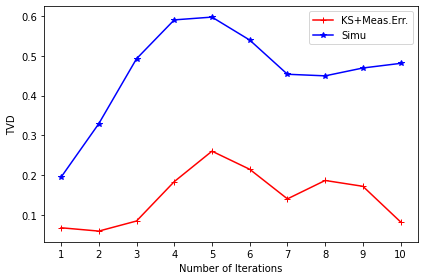

In [35]:
diff_fed_all= []
diff_fed_simu= []
for i in range(max_num_itrs):
    fed_difference_simu =  dist(real_probs[i].data, total_simu_dens[i].probabilities())
    KS_vec = np.array(total_smoother_dens[i].diagonal()).flatten().real
    noisy_KS_vec = cal_mat.dot(KS_vec)
    fed_difference_all =  dist(real_probs[i].data, noisy_KS_vec)
    diff_fed_all.append(fed_difference_all)
    diff_fed_simu.append(fed_difference_simu)
    print("Iteration",i+1, "KS Dist:", fed_difference_all, "Simu Dist:", fed_difference_simu)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS+Meas.Err.')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_simu)[iter_range], '*-', color='blue', label='Simu')
plt.xlabel("Number of Iterations")
plt.ylabel("TVD")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig(data_folder+backend.properties().to_dict()['backend_name']+"_diff_dist_4qubit.svg")
plt.show()

In [32]:
np.sum(diff_fed_all)

1.451918502037198